## Compare Random Forest in the case of binary class (Sell, Buy)

In [94]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    backtest_strategy,
    display_report,
    objective_random_forest,
    plot_feature_imp,
    plot_strategy,
    select_threshold,
)

In [49]:
METRIC = "precision"
TEST_SIZE = 400
FPR_MAX = 0.01
TIMEOUT = 600

In [50]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [51]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [52]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [53]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [54]:
interest_rate = wk_df["r"].values

## Baseline Random Forest Classifier without new data

In [55]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [56]:
# orig_df["r"] = interest_rate

### Split dataset

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [58]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_random_forest(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-14 20:05:55,491] A new study created in memory with name: no-name-a0ff7977-ed92-4b5e-b636-b75d701de458


[I 2024-02-14 20:06:04,527] Trial 0 finished with value: 0.6755394136648527 and parameters: {'max_features': 'sqrt', 'max_depth': 11, 'n_estimators': 192, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.6755394136648527.
[I 2024-02-14 20:06:12,827] Trial 1 finished with value: 0.6767768551222619 and parameters: {'max_features': 'sqrt', 'max_depth': 11, 'n_estimators': 193, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 1 with value: 0.6767768551222619.
[I 2024-02-14 20:06:15,939] Trial 2 finished with value: 0.6458097376389403 and parameters: {'max_features': 'sqrt', 'max_depth': 11, 'n_estimators': 61, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6767768551222619.
[I 2024-02-14 20:06:20,890] Trial 3 finished with value: 0.5298337427266309 and parameters: {'max_features': 'log2', 'max_d

Number of finished trials: 95
Best trial:
  Value: 0.713977005430898
  Params: 
    max_features: log2
    max_depth: 16
    n_estimators: 60
    min_samples_split: 6
    min_samples_leaf: 2
    bootstrap: False
    criterion: entropy


In [59]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier(**study.best_params, random_state=1968)),
    ]
)

In [60]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=16, max_features='log2',
                                        min_samples_leaf=2, min_samples_split=6,
                                        n_estimators=60, random_state=1968))])

In [61]:
# In-sample score
pipe.score(X_train, y_train)

0.9876425855513308

In [62]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.53


In [63]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [64]:
pipe.score(X_test, y_test)

0.4775

              precision    recall  f1-score   support

           0       0.68      0.25      0.37       236
           1       0.43      0.83      0.57       164

    accuracy                           0.49       400
   macro avg       0.56      0.54      0.47       400
weighted avg       0.58      0.49      0.45       400



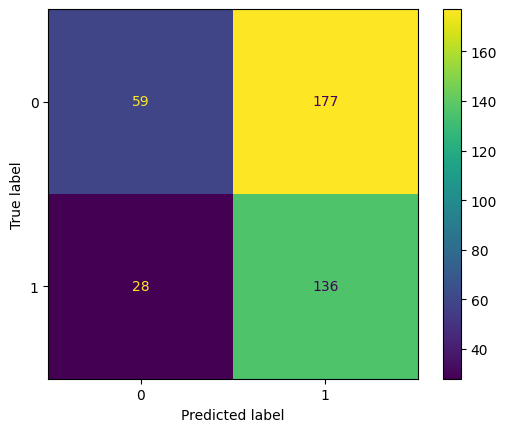

In [65]:
display_report(y_test, predictions)

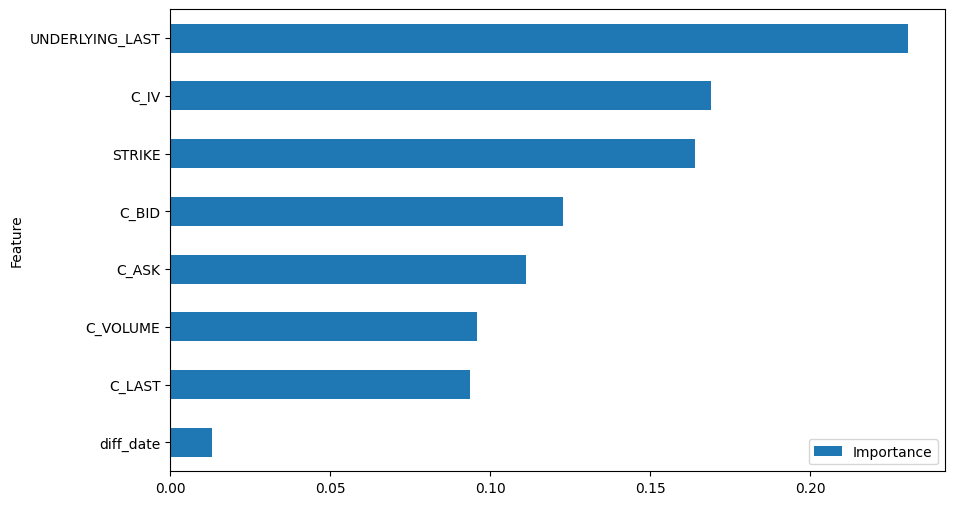

In [66]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [67]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_in"])

### Backtesting

In [68]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [69]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-03-14,1,416.0,11.15,2022-04-04,456.799988,29.649988,29.649988,29.649988,29.649988
2022-03-15,1,426.0,9.43,2022-04-04,456.799988,21.369988,21.369988,51.019976,51.019976
2022-03-16,0,436.0,7.90,2022-04-06,446.519989,0.000000,2.619989,51.019976,53.639965
2022-03-17,0,440.0,7.72,2022-04-06,446.519989,0.000000,-1.200011,51.019976,52.439954
2022-03-18,0,444.0,8.93,2022-04-08,447.570007,0.000000,-5.359993,51.019976,47.079961
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,192.129938,61.179850
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,192.129938,58.159843
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,192.129938,58.399835


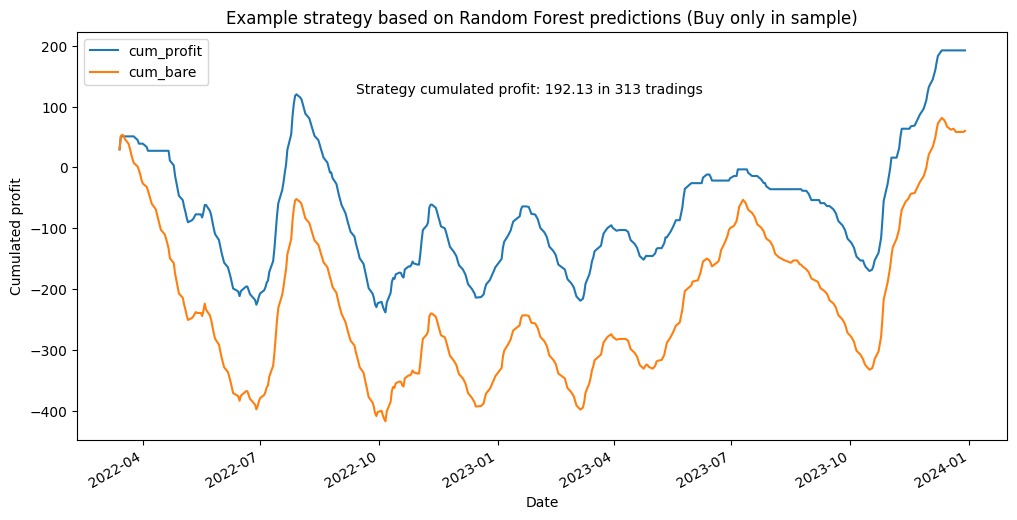

In [70]:
plot_strategy(strategy_df, "Random Forest", "(Buy only in sample)")

In [71]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## Random Forest with data from MC simulation and additional features

In [72]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [73]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [75]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=2048, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_random_forest(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT * 2,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-14 20:16:01,533] A new study created in memory with name: no-name-6bd0a282-cce2-4012-aacf-d0ad73d3f8b1
[I 2024-02-14 20:16:12,159] Trial 0 finished with value: 0.7569443585897666 and parameters: {'max_features': 'sqrt', 'max_depth': 16, 'n_estimators': 141, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.7569443585897666.
[I 2024-02-14 20:16:22,593] Trial 1 finished with value: 0.7575209650495445 and parameters: {'max_features': 'sqrt', 'max_depth': 17, 'n_estimators': 148, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.7575209650495445.
[I 2024-02-14 20:16:28,998] Trial 2 finished with value: 0.6066561236732355 and parameters: {'max_features': 'sqrt', 'max_depth': 4, 'n_estimators': 195, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.7575209650495445

Number of finished trials: 110
Best trial:
  Value: 0.7699719052020129
  Params: 
    max_features: log2
    max_depth: 18
    n_estimators: 197
    min_samples_split: 7
    min_samples_leaf: 2
    bootstrap: False
    criterion: gini


In [76]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier(**study.best_params, random_state=1968)),
    ]
)

In [77]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=18,
                                        max_features='log2', min_samples_leaf=2,
                                        min_samples_split=7, n_estimators=197,
                                        random_state=1968))])

In [78]:
# In-sample score
pipe.score(X_train, y_train)

0.9990494296577946

In [79]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.46


In [80]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [81]:
pipe.score(X_test, y_test)

0.465

              precision    recall  f1-score   support

           0       0.71      0.12      0.21       236
           1       0.42      0.93      0.58       164

    accuracy                           0.45       400
   macro avg       0.57      0.52      0.40       400
weighted avg       0.59      0.45      0.36       400



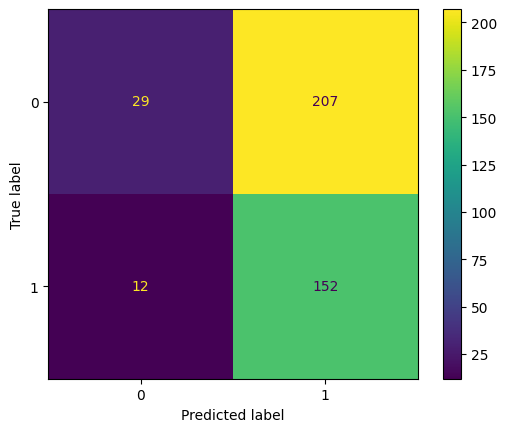

In [82]:
display_report(y_test, predictions)

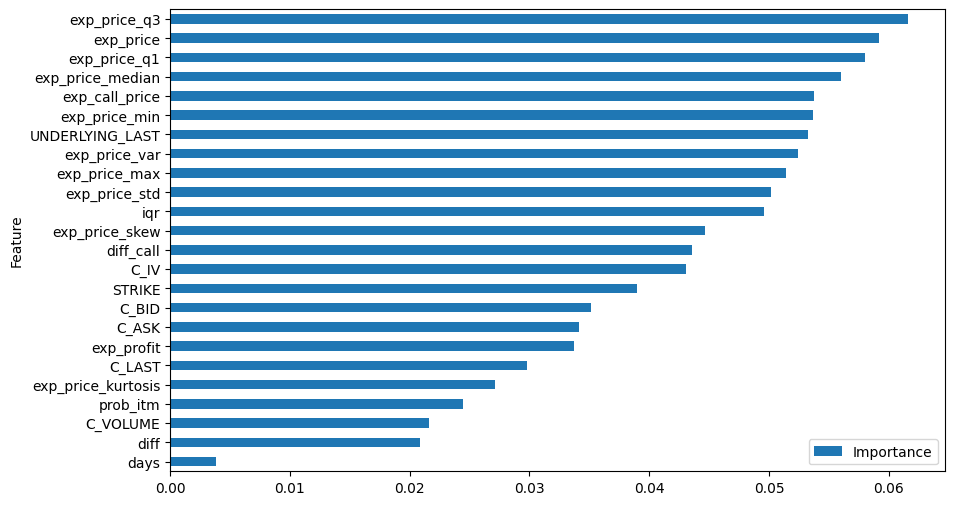

In [83]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [84]:
compare_df["mmar_rf_pred_in"] = predictions

### Backtesting

In [85]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [86]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-03-14,1,416.0,11.15,2022-04-04,456.799988,29.649988,29.649988,29.649988,29.649988
2022-03-15,1,426.0,9.43,2022-04-04,456.799988,21.369988,21.369988,51.019976,51.019976
2022-03-16,0,436.0,7.90,2022-04-06,446.519989,0.000000,2.619989,51.019976,53.639965
2022-03-17,0,440.0,7.72,2022-04-06,446.519989,0.000000,-1.200011,51.019976,52.439954
2022-03-18,0,444.0,8.93,2022-04-08,447.570007,0.000000,-5.359993,51.019976,47.079961
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,152.409921,61.179850
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,152.409921,58.159843
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,152.409921,58.399835


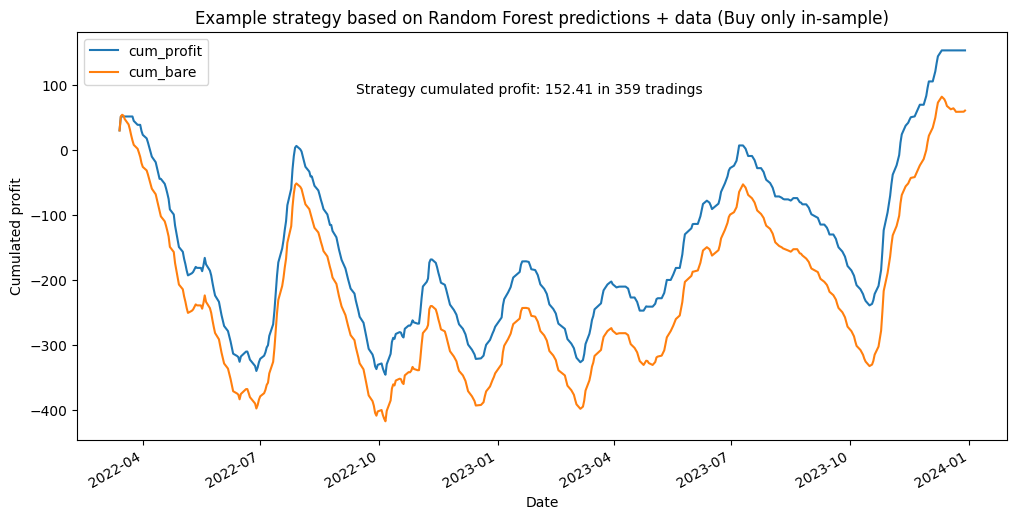

In [87]:
plot_strategy(strategy_df, "Random Forest", "+ data (Buy only in-sample)")

In [88]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [89]:
mask_in = (compare_df["bare_rf_pred_in"] - compare_df["mmar_rf_pred_in"]).astype(bool)

In [90]:
compare_df[mask_in]

,bare_rf_pred_in,cum_profit_out,mmar_rf_pred_in,mmar_cum_profit_out,mmar_cum_bare_out
9,0,51.019976,1,44.259976,7.509961
11,1,39.059976,0,38.209976,-4.450039
13,0,39.059976,1,28.779976,-20.380039
14,0,39.059976,1,22.839976,-26.320039
17,0,27.349976,1,3.869976,-45.290039
...,...,...,...,...,...
374,0,63.569988,1,36.949927,-56.140110
375,0,63.569988,1,41.399939,-51.690098
376,0,63.569988,1,45.949951,-47.140085
381,1,96.439972,0,69.039949,-14.270101


In [91]:
compare_df[mask_in].shape

(68, 5)

In [92]:
compare_df.sum(axis=0)

bare_rf_pred_in          313.000000
cum_profit_out        -28168.165961
mmar_rf_pred_in          359.000000
mmar_cum_profit_out   -61204.957582
mmar_cum_bare_out     -89134.646364
dtype: float64

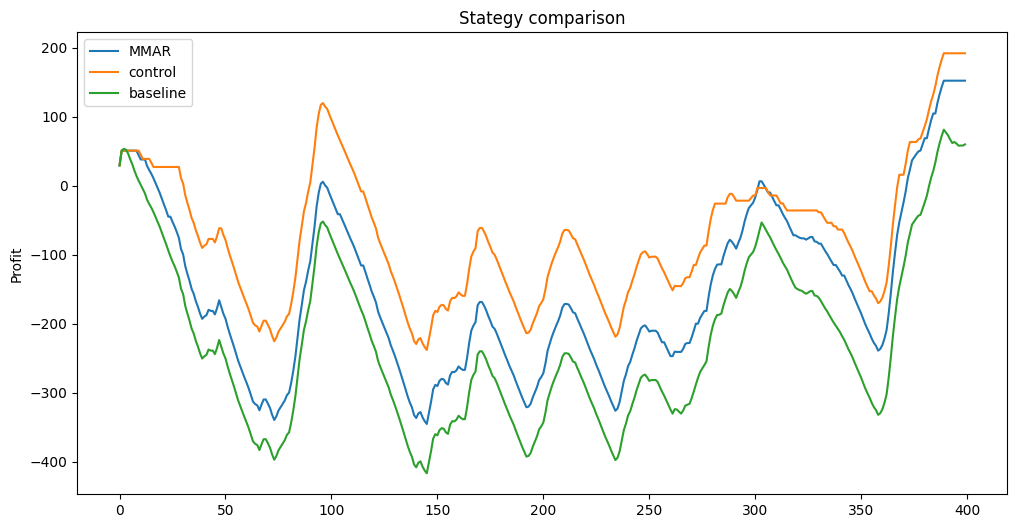

In [95]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")
plt.show()